# 0.0 Imports config e data

In [2]:
import math
import inflection
import datetime 
import seaborn as sns
import numpy   as np
import pandas  as pd 

from matplotlib import pyplot as plt
from scipy      import stats  as ss
from boruta     import BorutaPy

from matplotlib.gridspec   import GridSpec
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
print('Ok')

Ok


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option('display.max_rows', 100) 
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v(x, y):

    cm = pd.crosstab(x,y)
    cm = cm.values
    # print(cm,'\n')
    n= cm.sum()
    # print(n,'\n')
    r,k = cm.shape
    # print(cm.shape, '\n')

    chi2 = ss.chi2_contingency(cm)[0]
    # print(chi2,'\n')
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / ( min(kcorr-1, rcorr-1)))


In [3]:
jupyter_settings()

## 0.2 Loading data 

In [4]:
df_sales_raw = pd.read_csv("data/train.csv",low_memory = False)
df_store_raw = pd.read_csv('data/store.csv',low_memory = False)

In [5]:
df_store_raw.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [6]:
df_sales_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [7]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on= 'Store')

# 1.0 Passo 1- Data Decription 

## 1.1 Rename columns

In [8]:
df1 = df_raw.copy()
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
cols_new = list(map(lambda x: inflection.underscore( x ),cols))

df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print(f'Linhas : {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas : 1017209
Colunas: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1["date"])

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
%%timeit -n 5
df1.isna().sum()

212 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## 1.5 Fillout NA 

In [13]:
%%time
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                            
# promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval      
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',1:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

CPU times: user 47.5 s, sys: 665 ms, total: 48.2 s
Wall time: 48.2 s


## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [17]:
%%time
# Central Tenedency - mean, median
ct1 = (pd.DataFrame(num_attributes.apply(np.mean)).T)
ct2 = (pd.DataFrame(num_attributes.apply(np.median)).T)

# Description - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: np.max(x) - np.min(x) )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate

met = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
met.columns = ['Atributes', 'min','max','range','mean','median','std','skew','kurotosis']
met

CPU times: user 342 ms, sys: 29 μs, total: 342 ms
Wall time: 343 ms


,Atributes,min,max,range,mean,median,std,skew,kurotosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_3202/2697858400.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

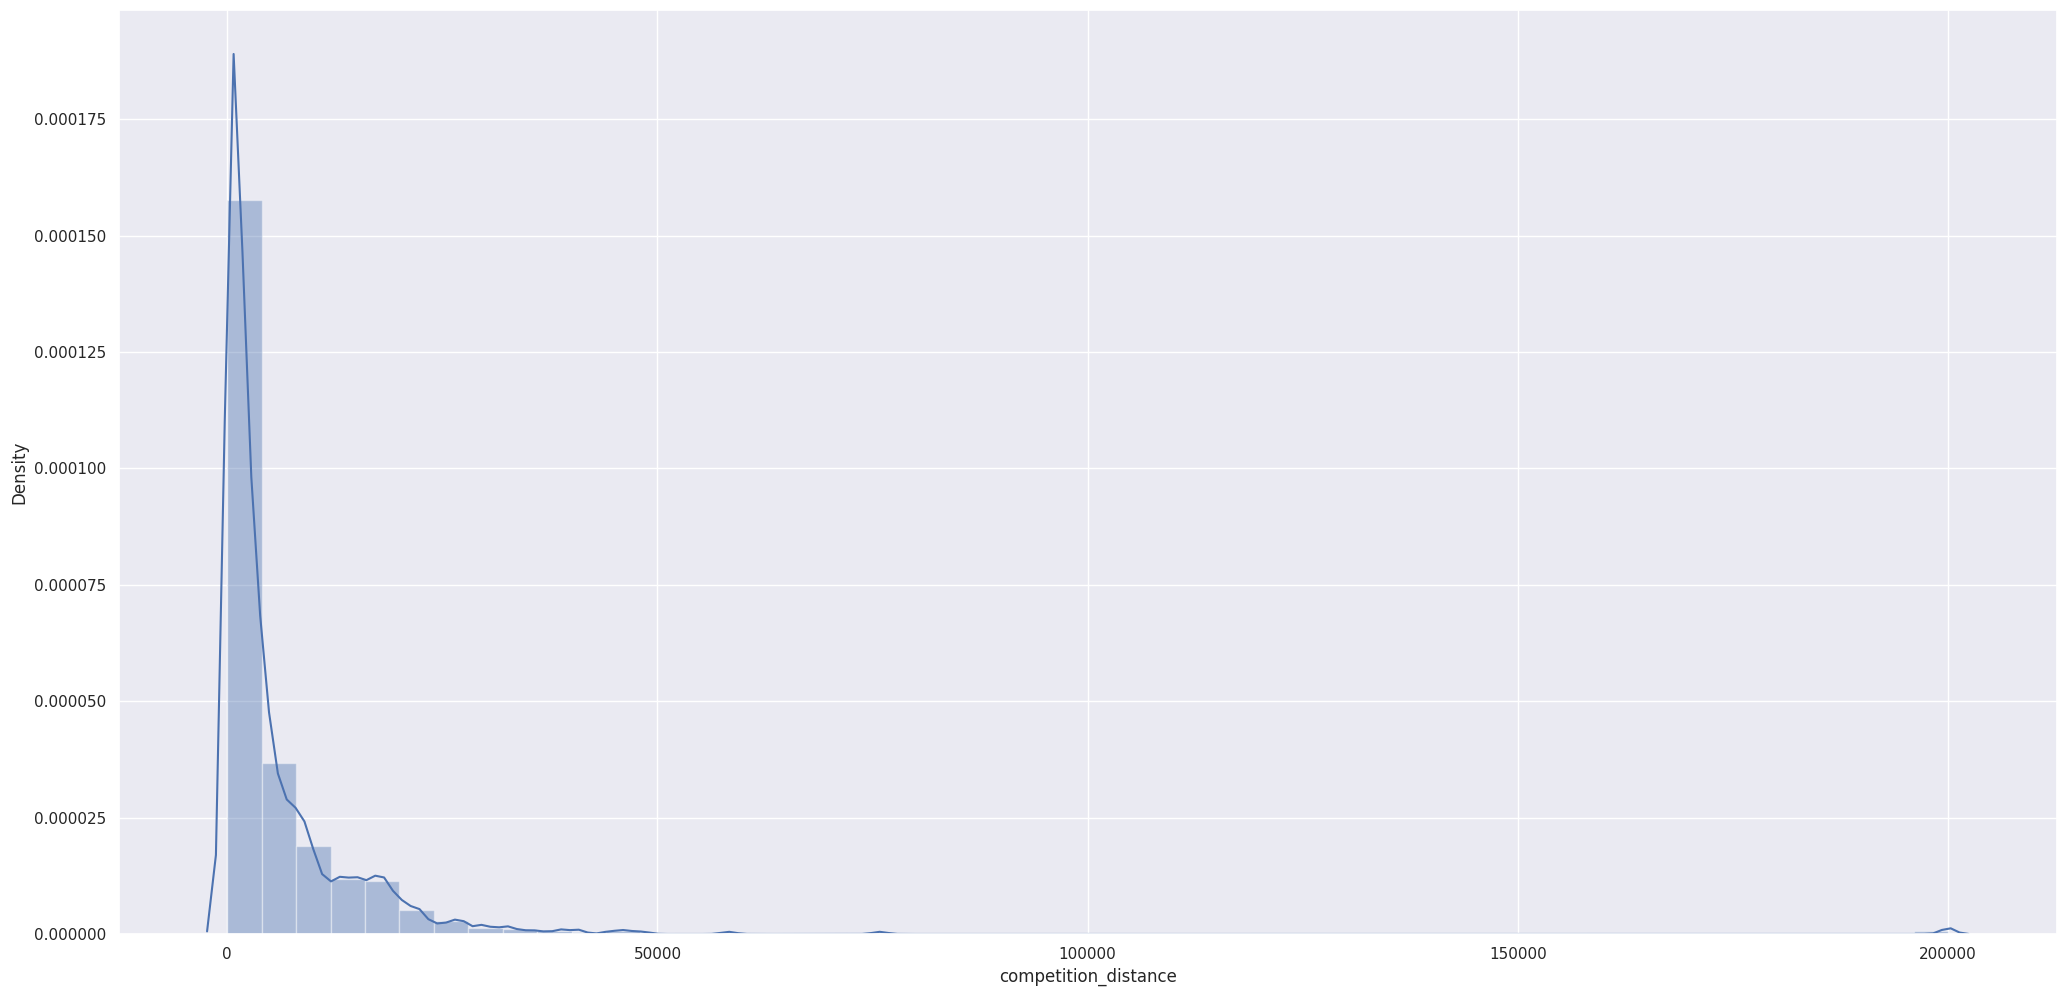

In [18]:
sns.distplot( df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique())
cat_attributes.apply(lambda x: x.unique().shape[0])


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

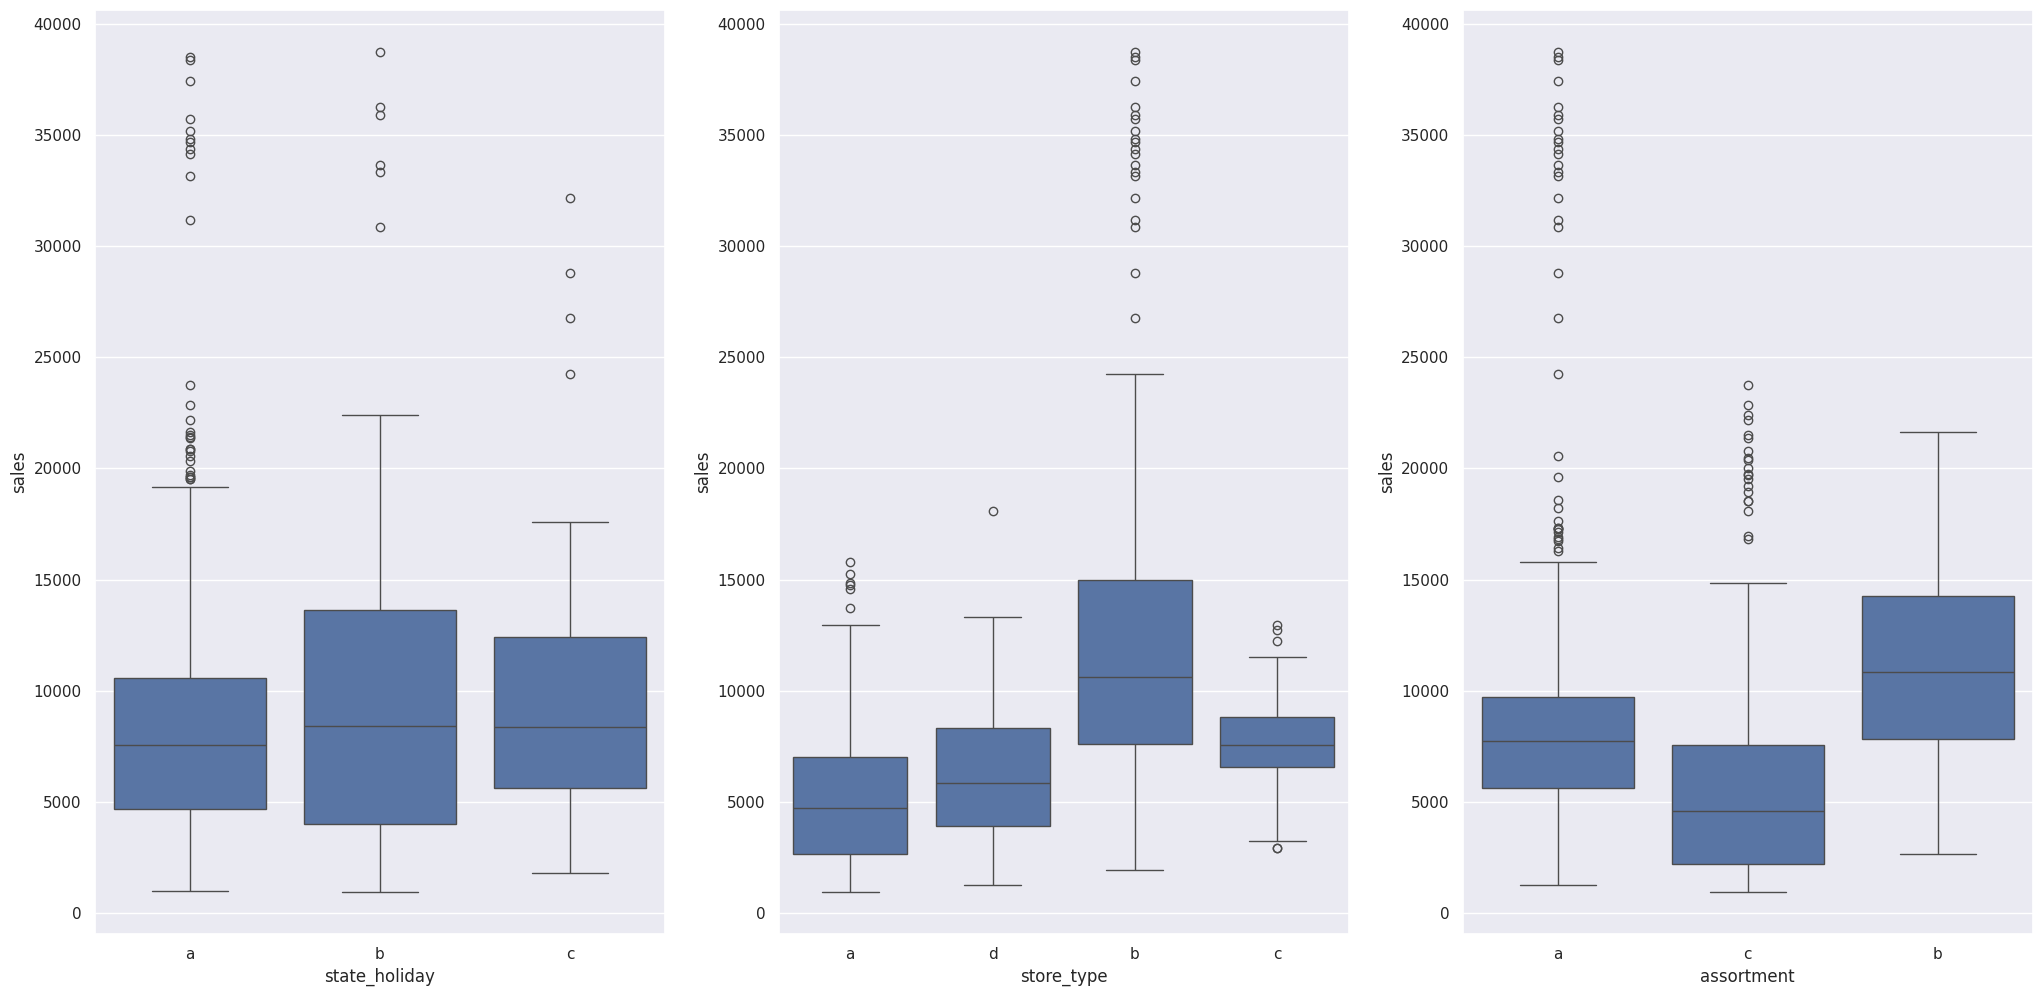

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x= 'state_holiday', y= 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y = 'sales', data = aux1)



# 2.0 Passo 2- Feature Engineering

In [21]:
df2 = df1.copy()

## 2.0.1 Negócio

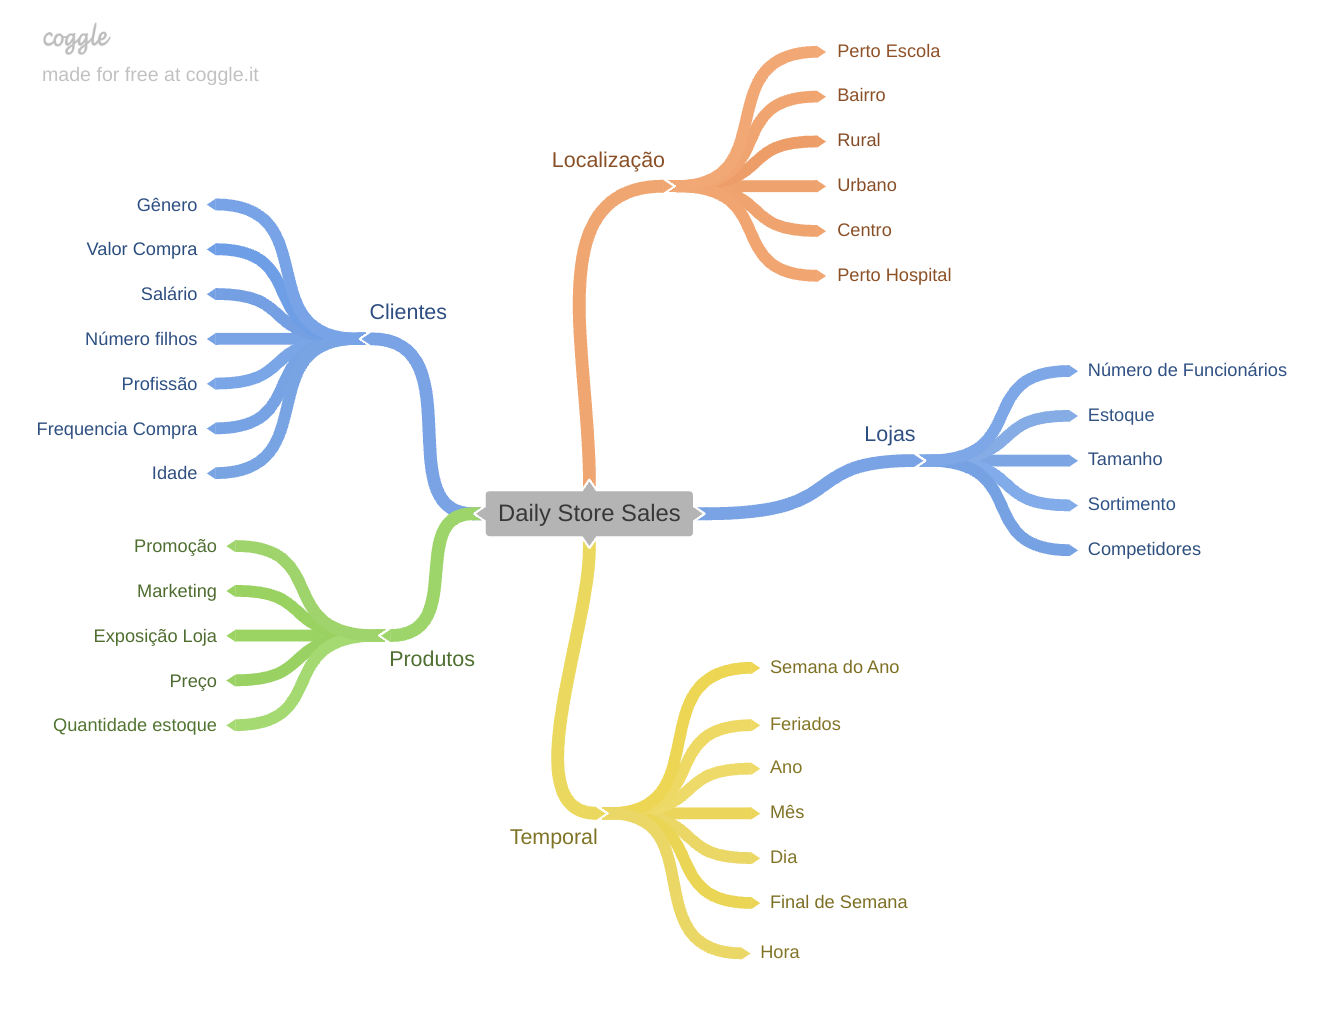

In [22]:
Image( 'img/imagem_hipoteses.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior tamanho deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto em vitrine deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas que fecham nos feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas abertas durante o feriado de natal deveriam vender mais.

**5.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**6.** Lojas deveriam vender menos durante feriados escolares

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções concecutivas deveriam vender mais.

**7.** Lojas que fecham nos feriados deveriam vender menos.

**8.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**9.** Lojas que abrem nos finais de semana deveriam vender mais.

**10.** Lojas abertas durante o feriado de natal deveriam vender mais.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos durante feriados escolares

## 2.3 Feature Engeneering

In [23]:
df1.head(1)
df2 = df1.copy()

In [24]:
%%time

df2 = df1.copy()
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['year_week'] = df2['date'].dt.strftime( "%Y-%W")

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year =x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w')- datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended' if x=='c' else x)

# state holiday
dict_state_holida= {'a':'public_holiday',
                   'b':'easter_holiday',
                   'c':'christmas',
                   'd':'regular_day',
                    '0':'regular_day'}

df2['state_holiday'] = df2['state_holiday'].map(dict_state_holida)

CPU times: user 32.5 s, sys: 559 ms, total: 33.1 s
Wall time: 33.1 s


# 3.0 Passo 3- Filtragem de Variáveis

In [25]:
df3 = df2.copy()
df3.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279


## 3.1 Filtragem de Linhas 

In [26]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 1) ]


## 3.2 Seleção de colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 
df3 = df3.drop (cols_drop, axis =1 )

# 4.0 Passo 4- Análise Exploratória de Dados

In [28]:
df4 = df3.copy()

## 4.1 Analise Univariada 

### 4.1.1 Response Variable 

<Axes: xlabel='sales', ylabel='Count'>

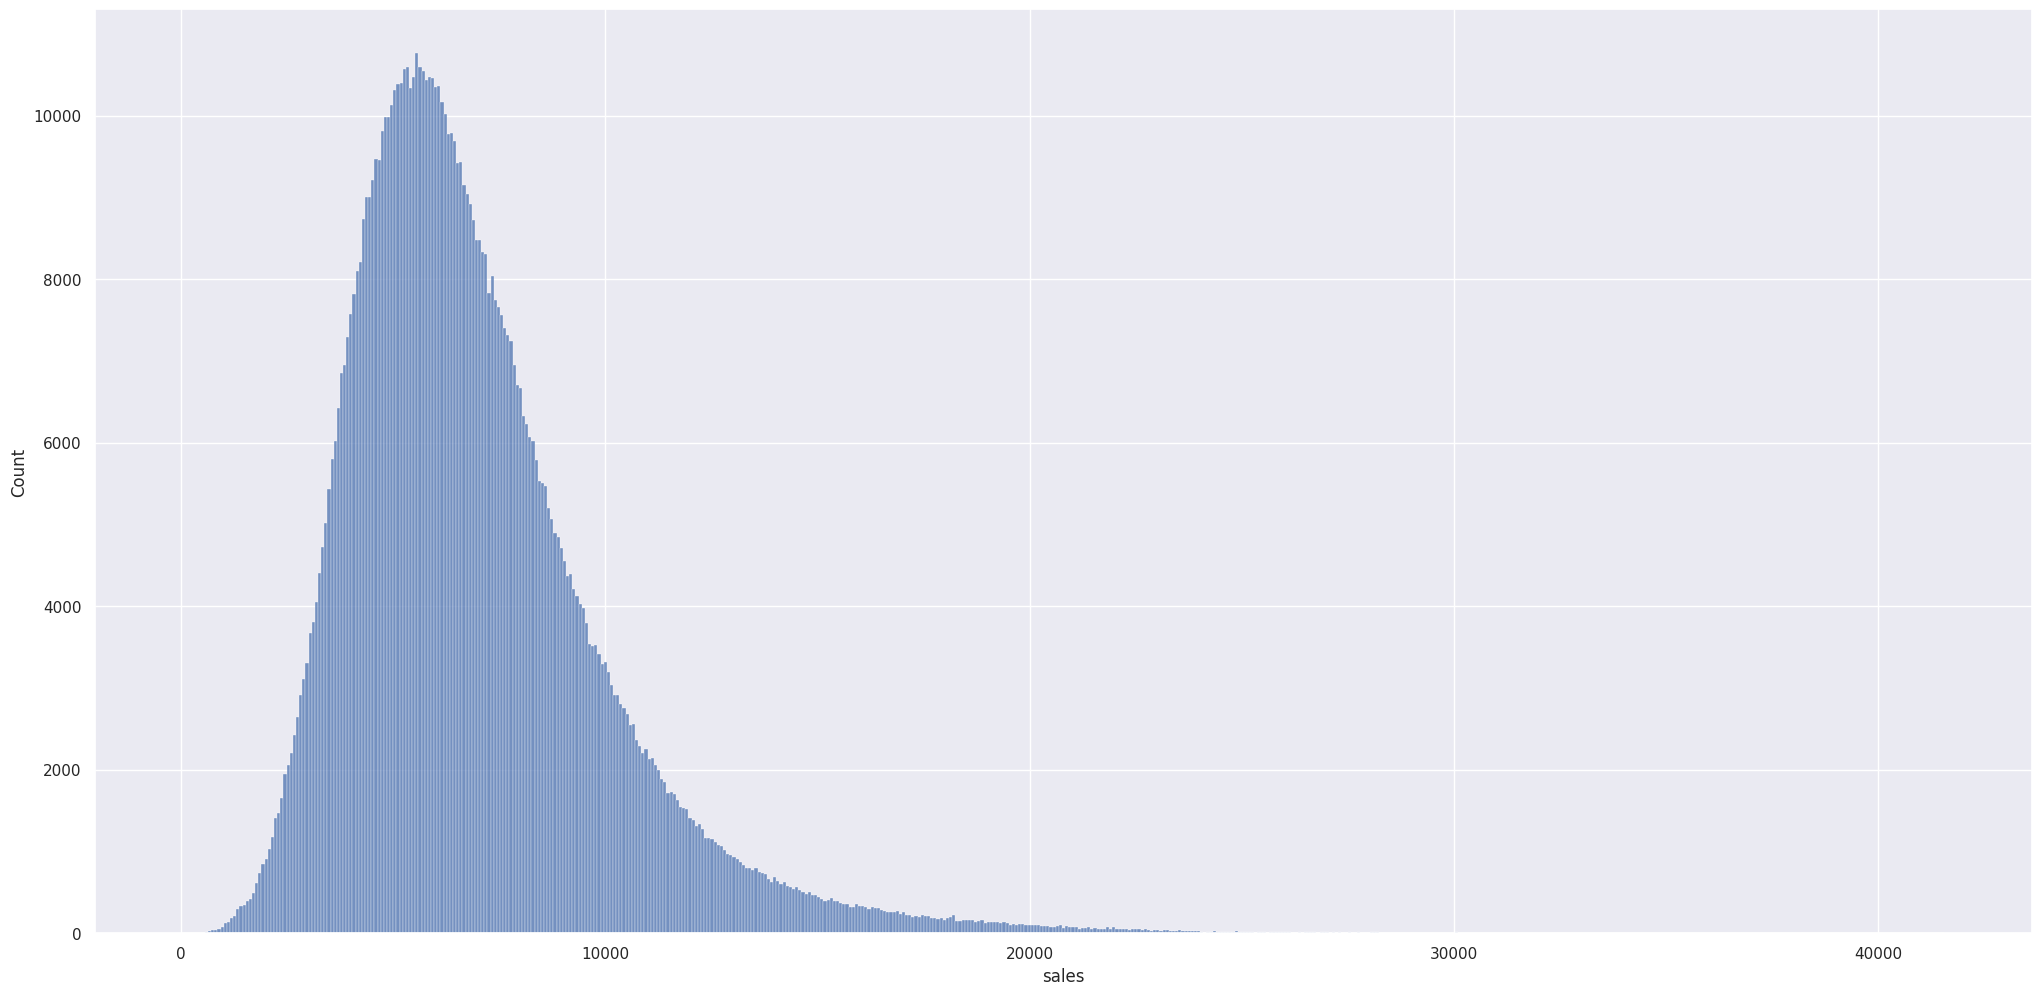

In [29]:
sns.histplot(df4['sales'])

### 4.1.2 Numerical Variable

In [30]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64', 'int32'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

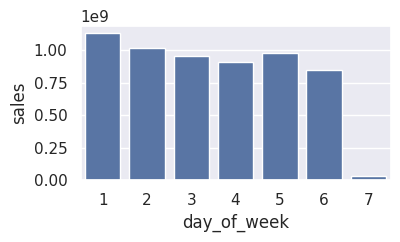

In [31]:
dfaux = df4.loc[:,['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize = (4,2))
sns.barplot(x='day_of_week', y='sales', data=dfaux);

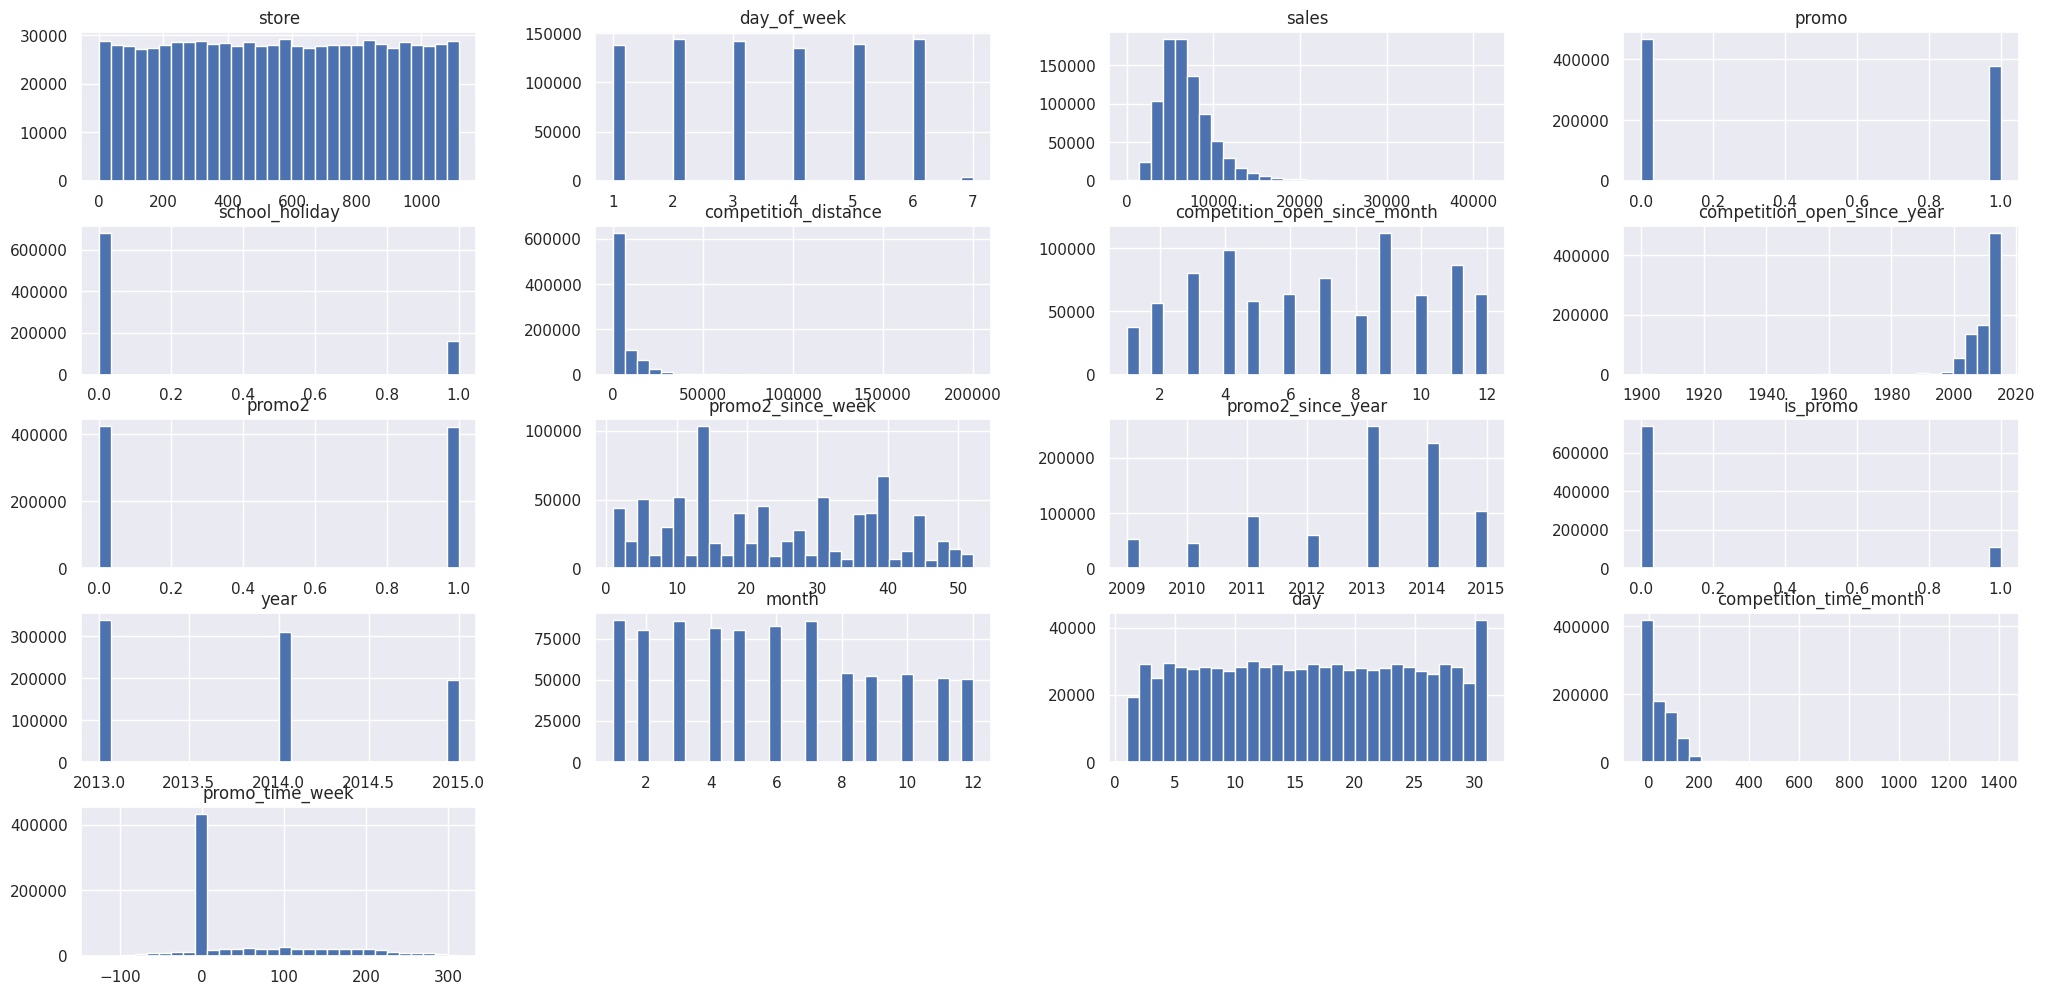

In [32]:
num_attributes.hist(bins = 30);

### 4.1.3 Categorical Variale

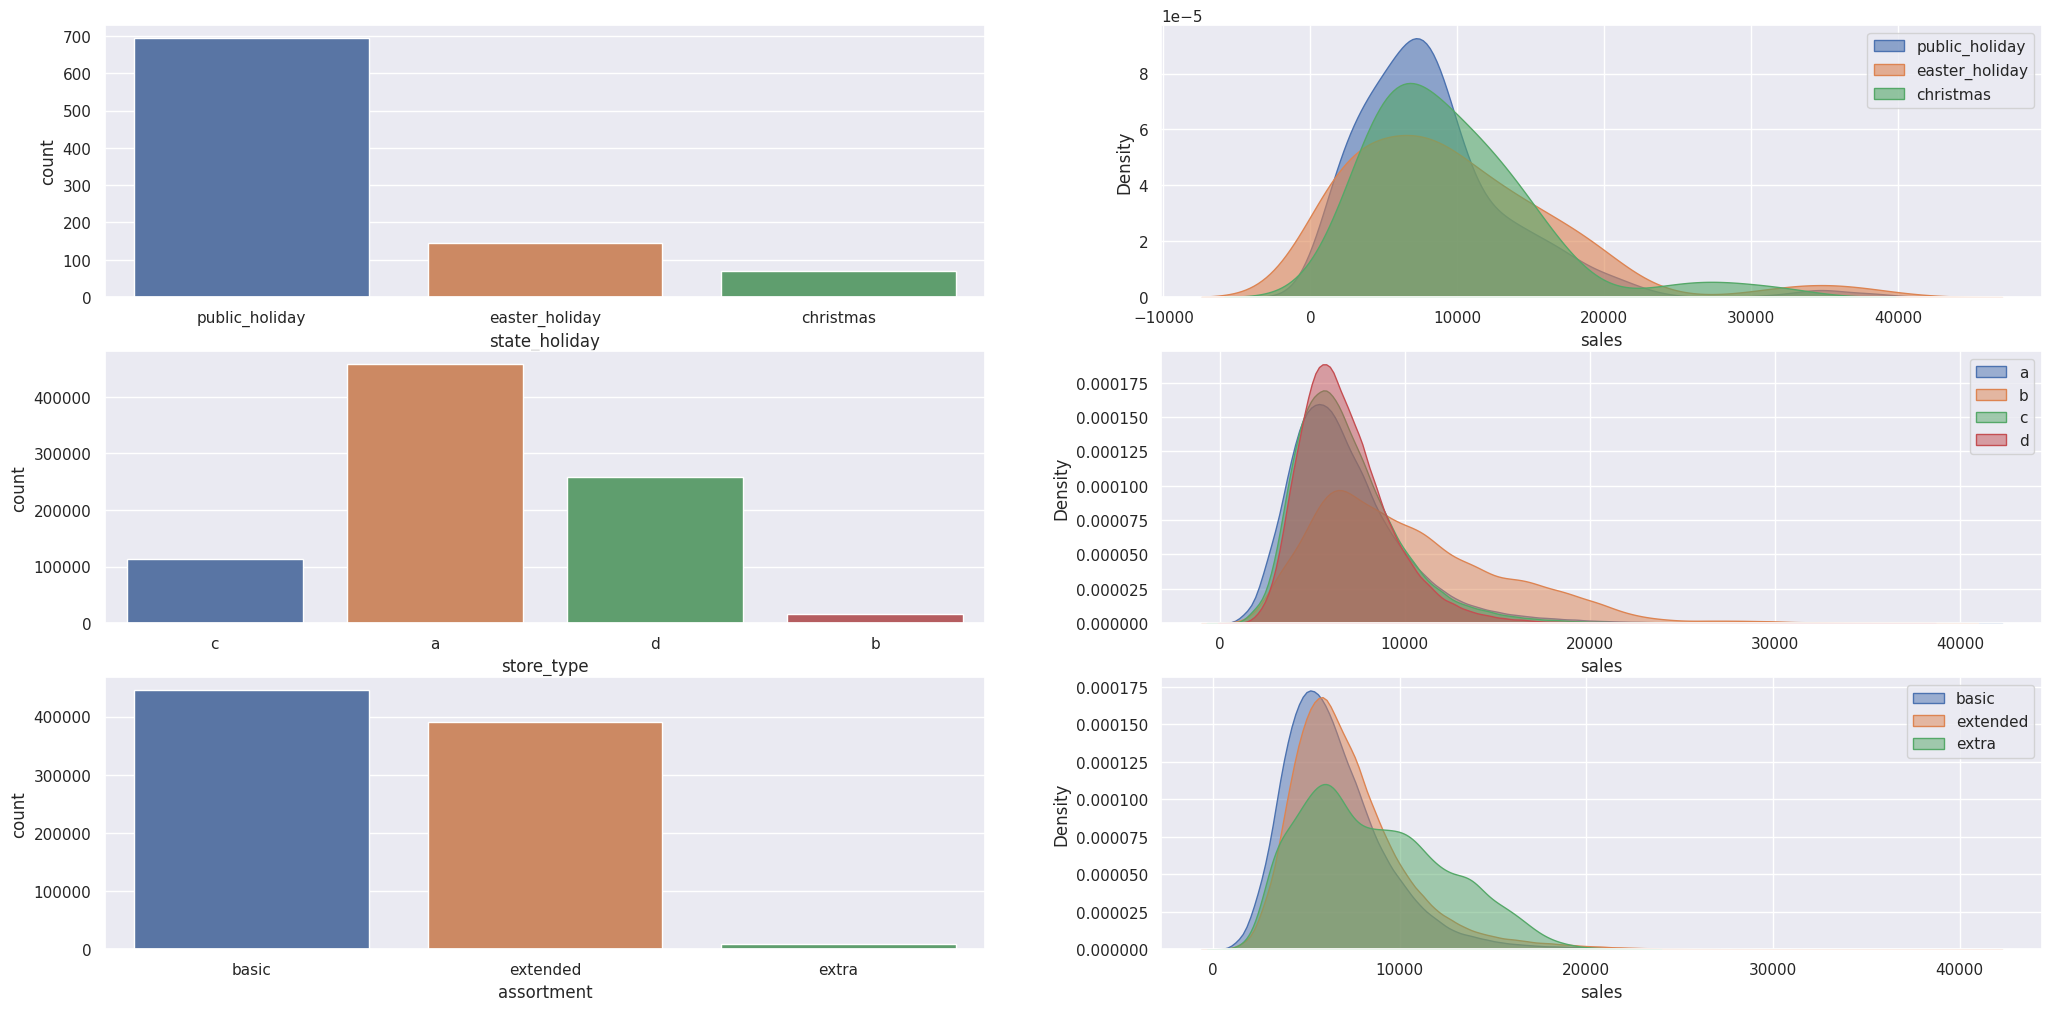

In [33]:
# sns.set_palette('deep')

# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday']!= 'regular_day']
sns.countplot(x=a['state_holiday'], hue = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label = 'public_holiday', fill = True, alpha = 0.6)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label = "easter_holiday", fill = True, alpha = 0.6)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label = "christmas", fill = True, alpha = 0.6)
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'], hue = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label = 'a', fill = True, alpha = 0.5)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label = "b", fill = True, alpha = 0.5)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label = "c", fill = True, alpha = 0.5)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label = "d", fill = True, alpha = 0.5)
plt.legend()

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'], hue = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label = 'basic', fill = True, alpha = 0.5)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label = "extended", fill = True, alpha = 0.5)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label = "extra", fill = True, alpha = 0.5)
plt.legend();


## 4.2 Análise Bivariada

### H1 Lojas com maior sortimento deveriam vender mais.
**VERDADEIRA** Lojas com sortimento extra e extended tem medias de venda maior, mas tem uma menor quantidade de lojas se comparadas com o tipo basic

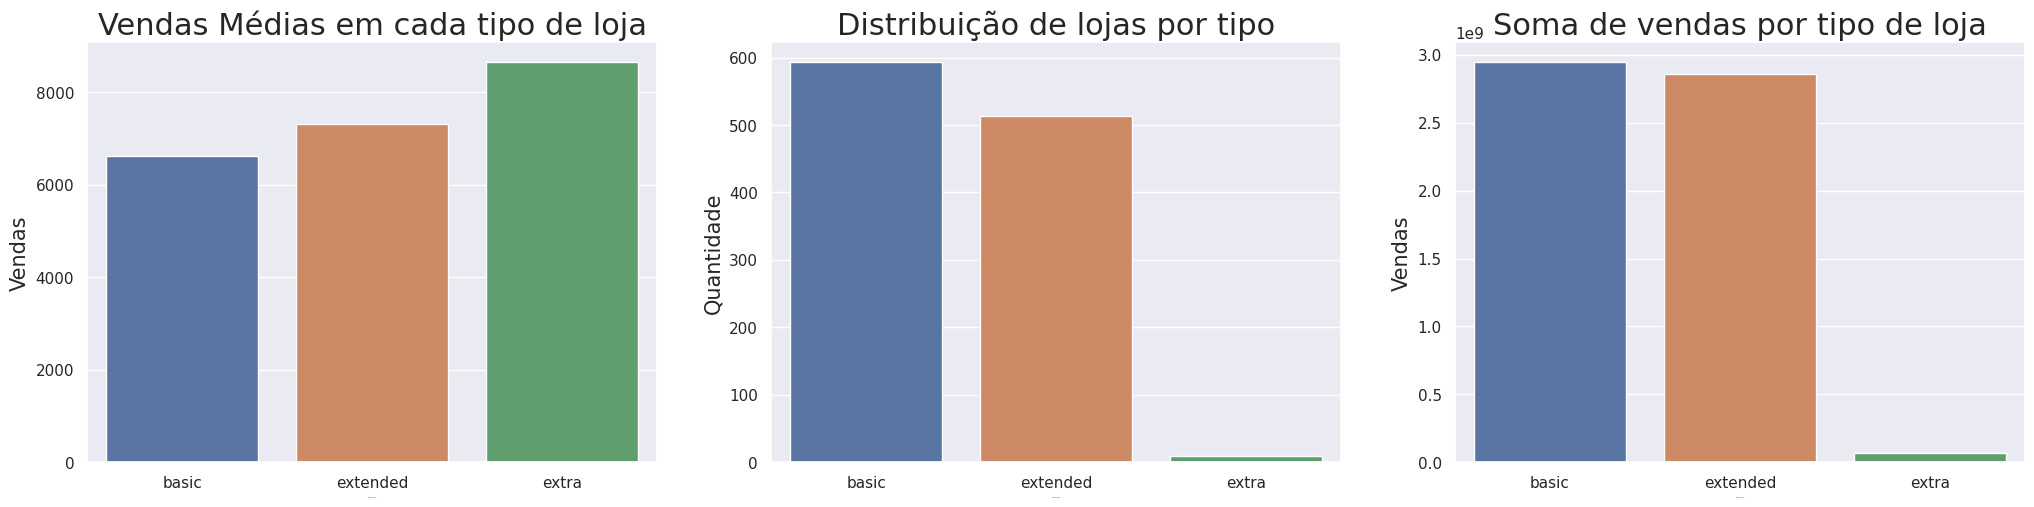

In [34]:
# 'basic', 'extended', 'extra'
plt.subplot(2,3,1)
plt.title('Vendas Médias em cada tipo de loja', size = 22)
plt.xlabel('Tipo de loja', size = 0.0001)
plt.ylabel('Vendas', size = 15)
comp_sort = df4.loc[:,['assortment', 'sales']].groupby('assortment').mean('sales').reset_index()
comp_sort['sales'] = [round(num, 2) for num in comp_sort['sales']]
sns.barplot(x ='assortment', y= 'sales', data = comp_sort, hue = 'assortment');

plt.subplot(2,3,2)
plt.title('Distribuição de lojas por tipo', size = 22)
plt.xlabel('Tipo de loja', size = 0.0001)
plt.ylabel('Quantidade', size = 15)
comp_sort = df4.loc[:,['assortment', 'store']].groupby('assortment').nunique().reset_index()
sns.barplot(x='assortment',y ='store', data = comp_sort, hue = 'assortment')

plt.subplot(2,3,3)
plt.title('Soma de vendas por tipo de loja', size = 22)
plt.xlabel('Tipo de loja', size = 0.0001)
plt.ylabel('Vendas', size = 15)
comp_sort = df4.loc[:,['assortment', 'sales']].groupby('assortment').sum('sales').reset_index()
comp_sort['sales'] = [round(num, 2) for num in comp_sort['sales']]
sns.barplot(x ='assortment', y= 'sales', data = comp_sort, hue = 'assortment');

### H2 Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com competidores de distintas distâncias tem uma mediana de vendas muito similar.

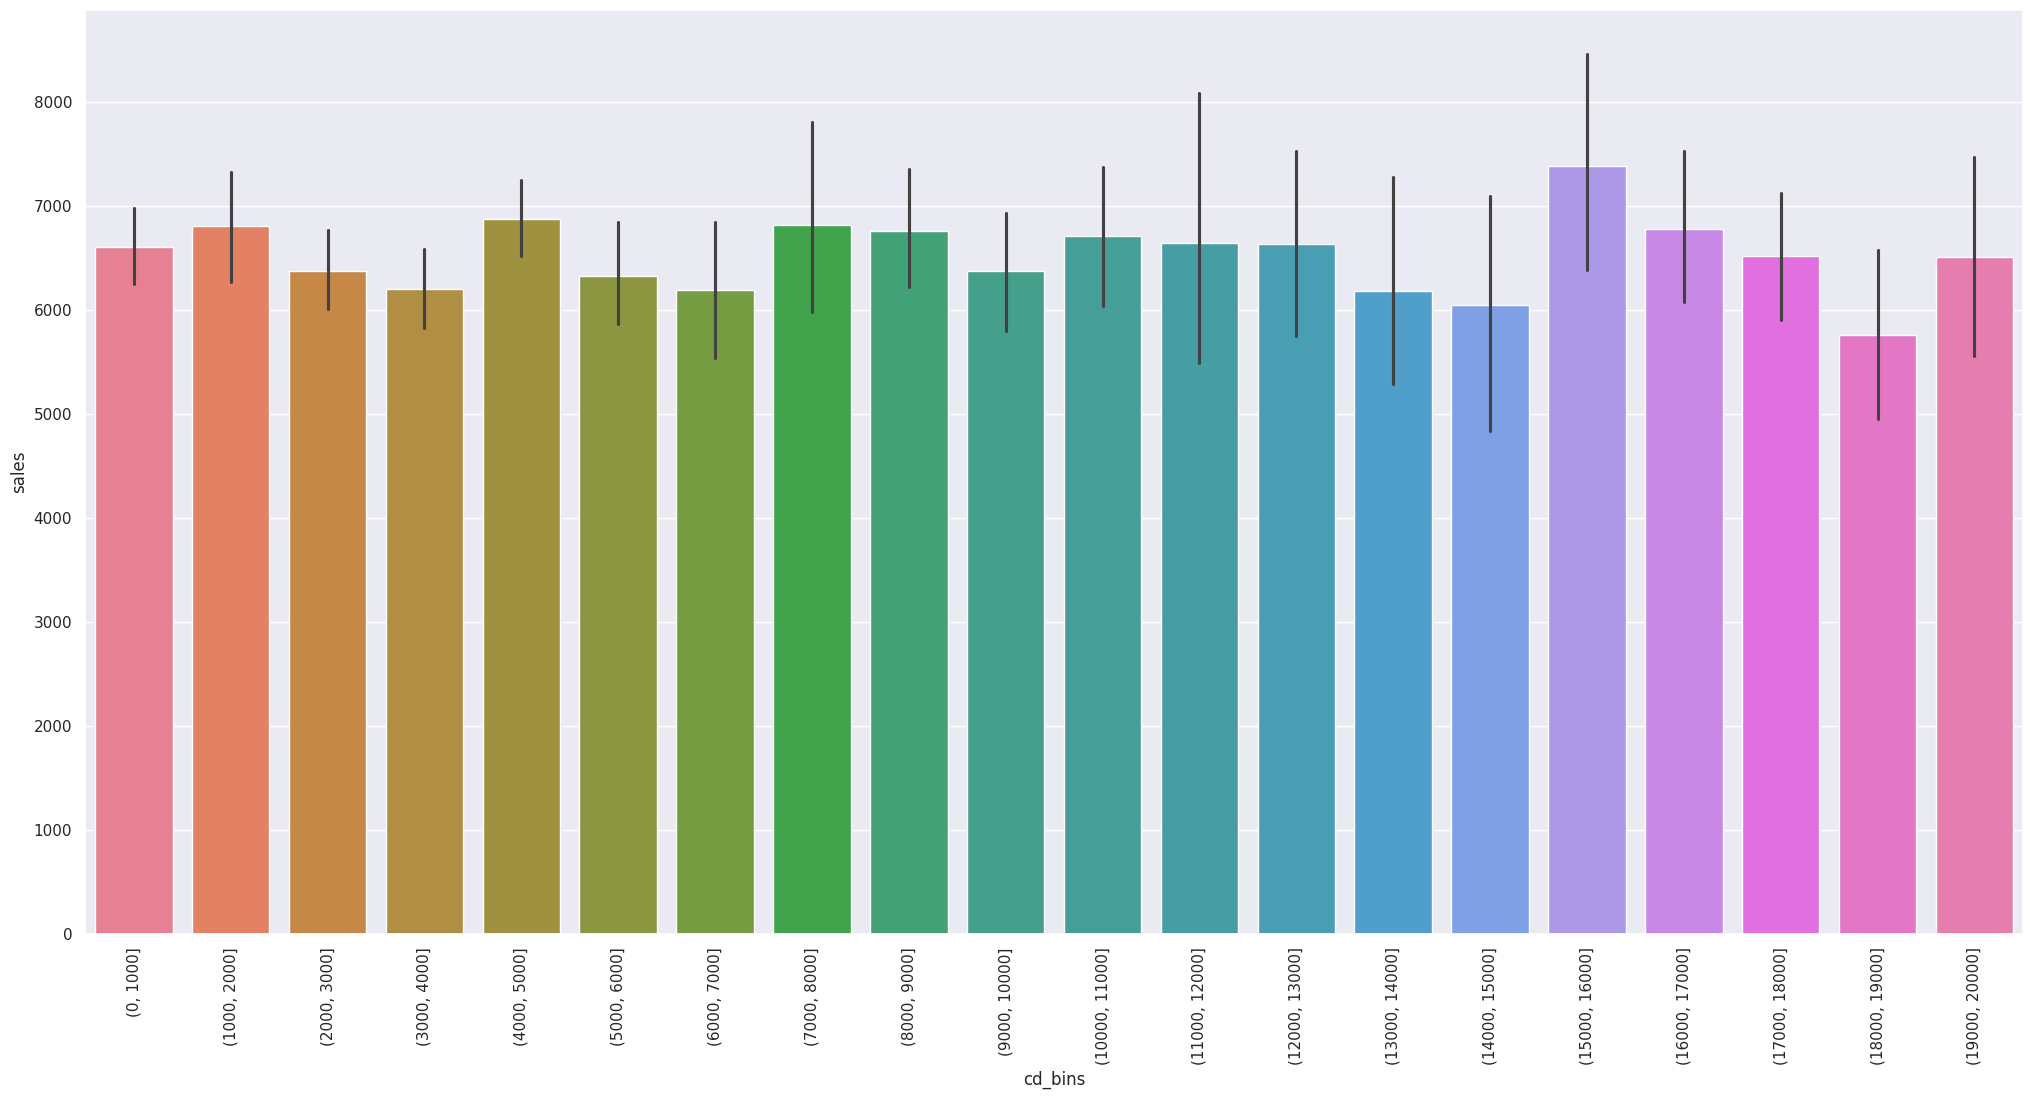

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

bins = list(np.arange(0,20001,1000))

aux1['cd_bins'] = pd.cut(aux1['competition_distance'], bins = bins)

aux2 = aux1[['cd_bins', 'sales']].groupby('cd_bins',observed=True).median("sales").reset_index()

sns.barplot(x='cd_bins',y='sales', data = aux1, hue = 'cd_bins' )
plt.legend().remove()
plt.xticks(rotation = 90);

### H3 Lojas com competidores a mais tempo deveriam vender menos.
**FALSA** Lojas com competidores a pouco tempo tendem a ter uma diminuição das vendas porém após 150 semanas é possivel ver uma dispersão positiva entre os dados, que pode demonstrar uma dominância local ou estabilidade nas vendas.

<Axes: xlabel='competition_time_month', ylabel='sales'>

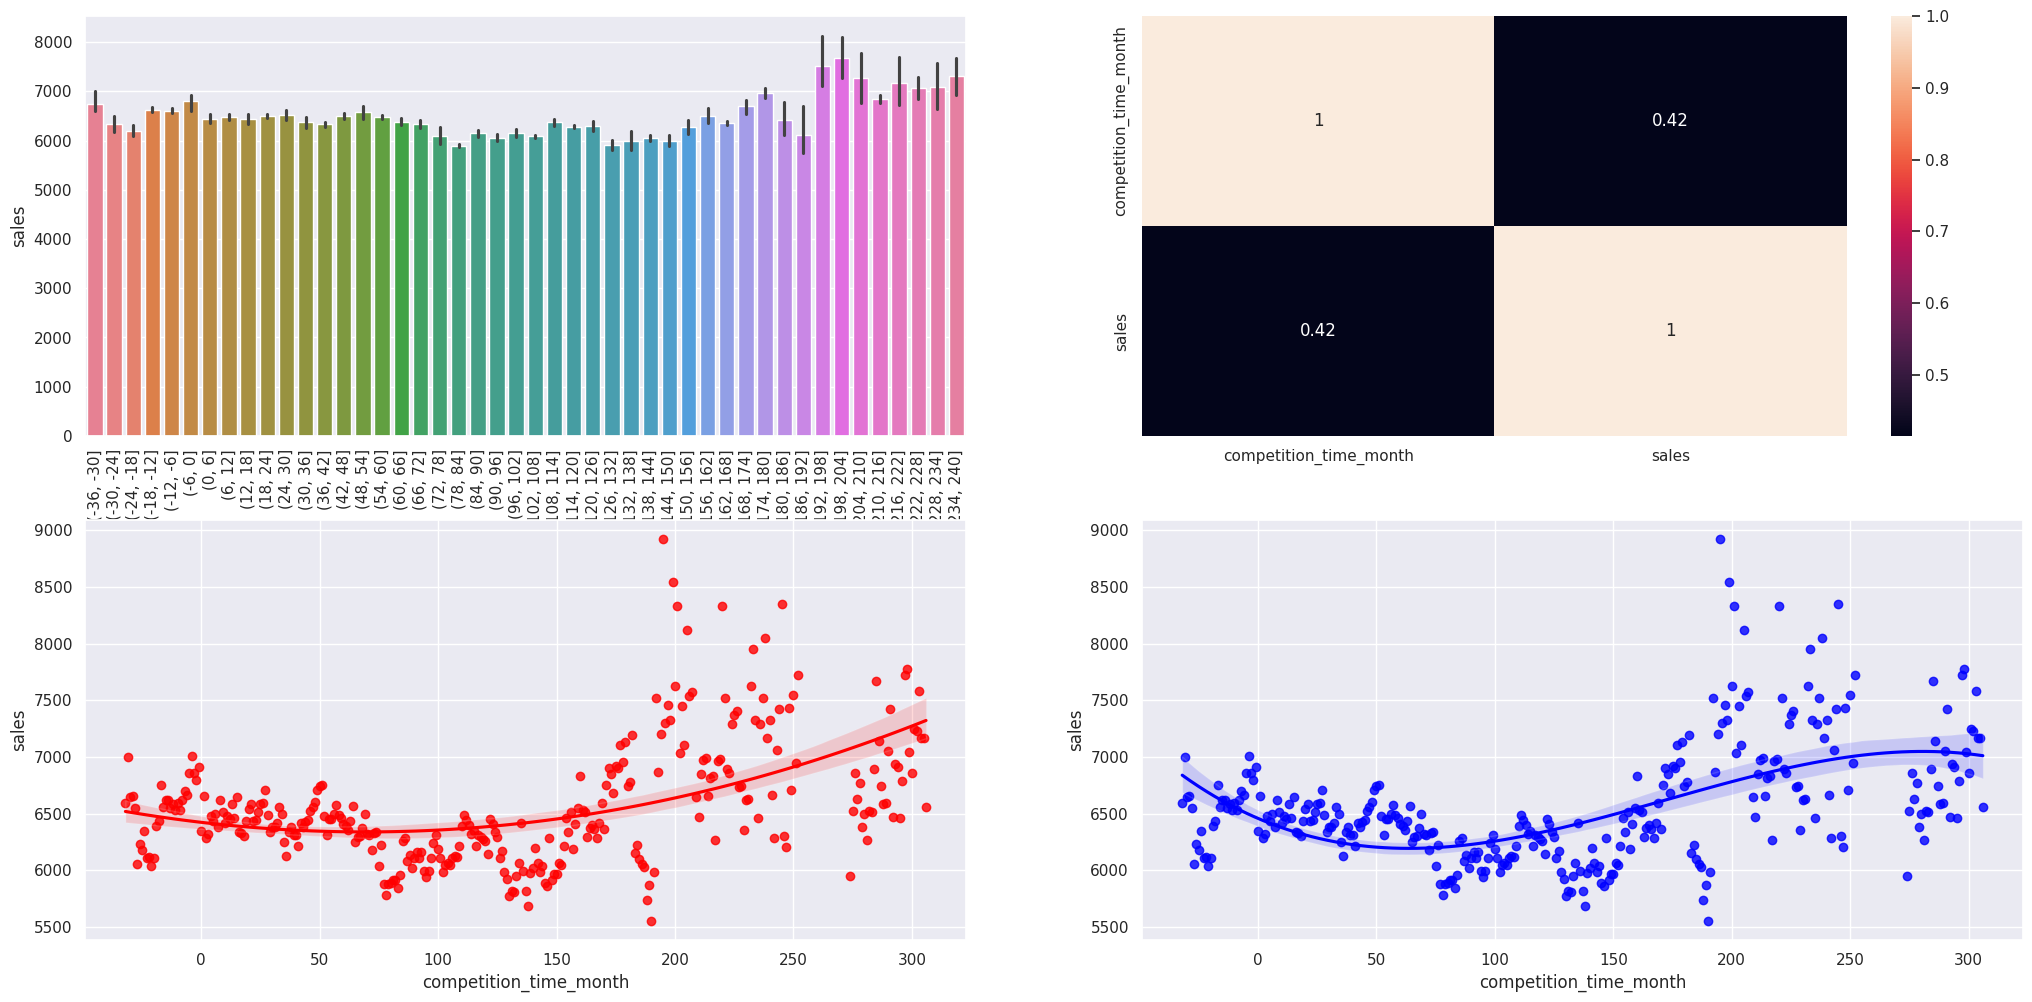

In [36]:
dfaux1 = (df4.loc[(df4['competition_time_month']>=-36)&(df4['competition_time_month']<=240) ,['competition_time_month', 'sales']]
         .groupby('competition_time_month')
         .median()
         .reset_index())

bins = list(np.arange(-36,241,6))
dfaux1['cd_bins'] = pd.cut(dfaux1['competition_time_month'], bins = bins)

plt.subplot(2,2,1)
sns.barplot(x='cd_bins', y= "sales", data = dfaux1, hue = 'cd_bins')
plt.xticks(rotation=90);
plt.legend().remove()

dfaux2 = (df4.loc[(df4['competition_time_month']>=-50)&(df4['competition_time_month']<400) ,['competition_time_month', 'sales']]
         .groupby('competition_time_month')
         .median()
         .reset_index())

plt.subplot(2,2,2)
x = sns.heatmap(dfaux2.corr(method='pearson'), annot = True)

plt.subplot(2,2,3)
sns.regplot(x='competition_time_month', y='sales', data=dfaux2, order=2, color='red');

plt.subplot(2,2,4)
# Adicionar linha de tendência polinomial de grau 2
sns.regplot(x='competition_time_month', y='sales', data=dfaux2, order=3, color='blue')


### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
***VERDADEIRA*** Lojas com promoção ativa a mais tempo tendem a ter mais vendas na mediana

In [37]:
colunas_promo =  [coluna for coluna in list(df4.columns) if 'promo' in coluna ]
colunas_promo.insert(0,'date')
colunas_promo.insert(2,'sales')
colunas_promo.insert(3,'year_week')

df_promo = df4[colunas_promo]

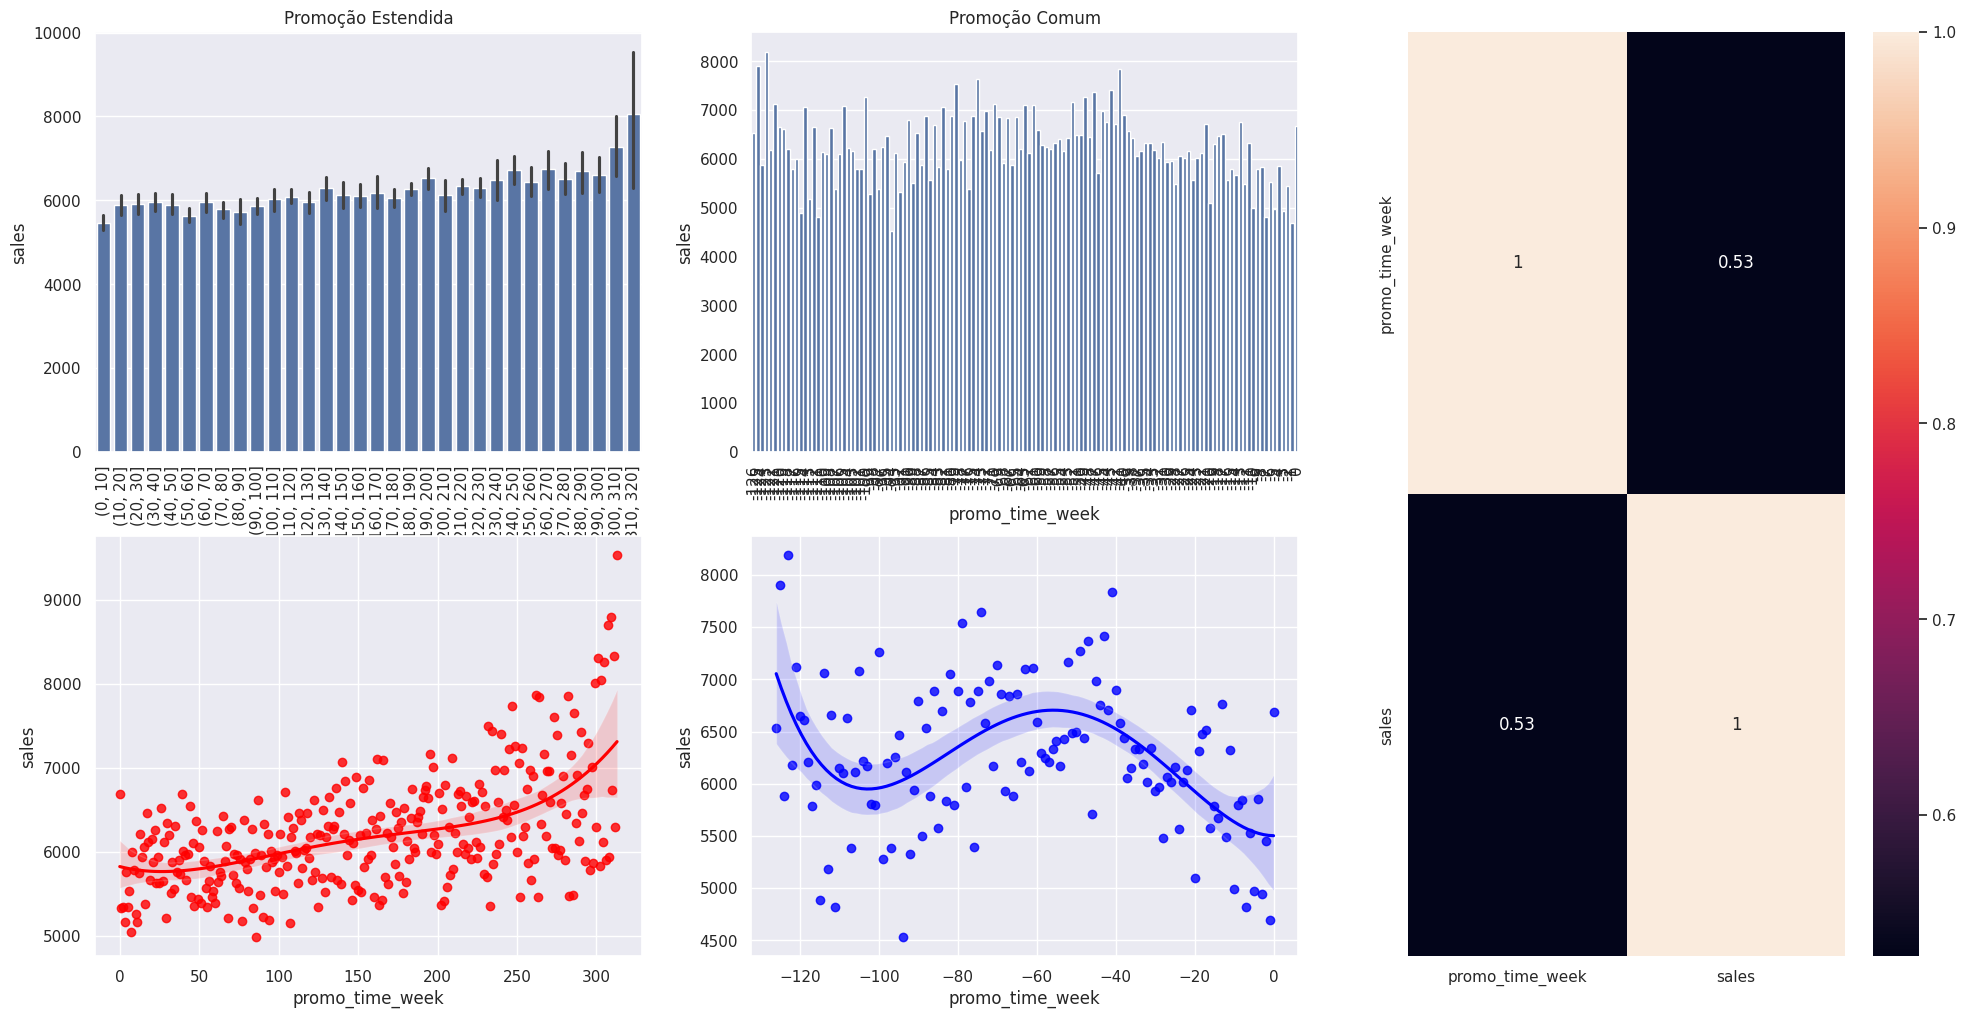

In [38]:
dfaux1 = df_promo.loc[df_promo['promo_time_week']>=0, ['promo_time_week', 'sales']].groupby('promo_time_week').median().reset_index()
bins = list(np.arange(0,321, 10))
dfaux1['promo_bins'] = pd.cut(dfaux1['promo_time_week'], bins = bins)

dfaux2 = df_promo.loc[df_promo['promo_time_week']<=0, ['promo_time_week', 'sales']].groupby('promo_time_week').median().reset_index()
# dfaux2['promo_time_week'] = np.abs(dfaux2['promo_time_week'])

plt.figure(figsize=(24, 12)) 
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
# plt.bar(dfaux1['promo_time_week'], dfaux1['sales'], color = 'blue')
sns.barplot(x= 'promo_bins', y= 'sales', data= dfaux1 )
plt.xticks(rotation=90)
plt.title('Promoção Estendida')

plt.subplot(grid[0,1])
sns.barplot(x= 'promo_time_week', y= 'sales', data= dfaux2  )
plt.xticks(rotation=90)
plt.title('Promoção Comum');

plt.subplot(grid[1,0])
sns.regplot(x= 'promo_time_week', y= 'sales', data = dfaux1, order=4, color='red')

plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data = dfaux2, order=4, color='blue');

plt.subplot(grid[:,2])
sns.heatmap(dfaux1[['promo_time_week','sales']].corr(method='pearson'), annot = True);

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s> 

### H6. Lojas com mais promoções concecutivas deveriam vender mais.
**FALSA** Lojas com promo e promo2 vendem menos que lojas com apenas promo ativa, e lojas com promo2 ativa vendem menos que lojas sem promo

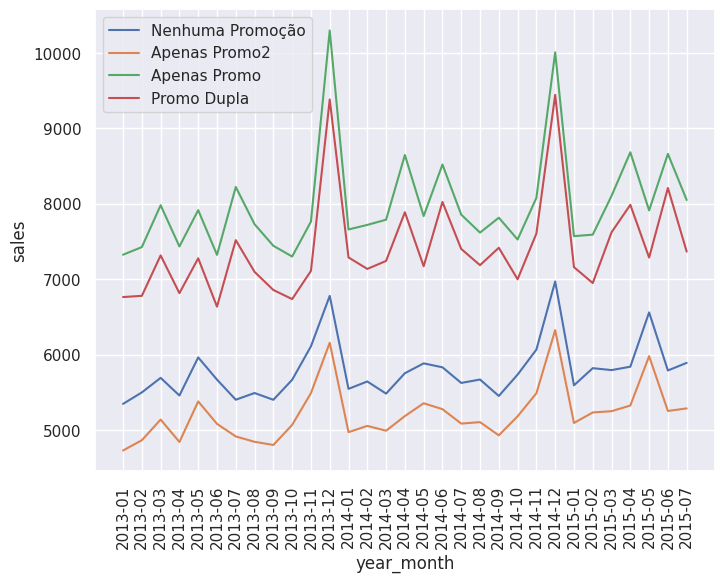

In [39]:
df4["year_month"]= df4['date'].dt.strftime( "%Y-%m")
dfaux1 = df4[['year_month','promo' ,'promo2', 'sales']].groupby(['year_month', 'promo', 'promo2']).median('sales').reset_index()
dfaux1['num_promo'] = dfaux1.apply(lambda x: 'Nenhuma Promoção' if x['promo']== 0 and x['promo2'] ==0 else
                                             'Apenas Promo' if x['promo']== 1 and x['promo2'] == 0 else
                                             'Apenas Promo2' if x['promo']== 0 and x['promo2'] ==1 else 
                                             'Promo Dupla', axis=1)

plt.figure(figsize=(8,6))
sns.lineplot(x='year_month', y='sales', hue='num_promo', data=dfaux1)
plt.legend()
plt.xticks(rotation = 90);

### **H7** Lojas tendem a vender mais ao longo dos anos
**FALSA** Houve uma redução na quantidade de vendas ao decorrer do tempo

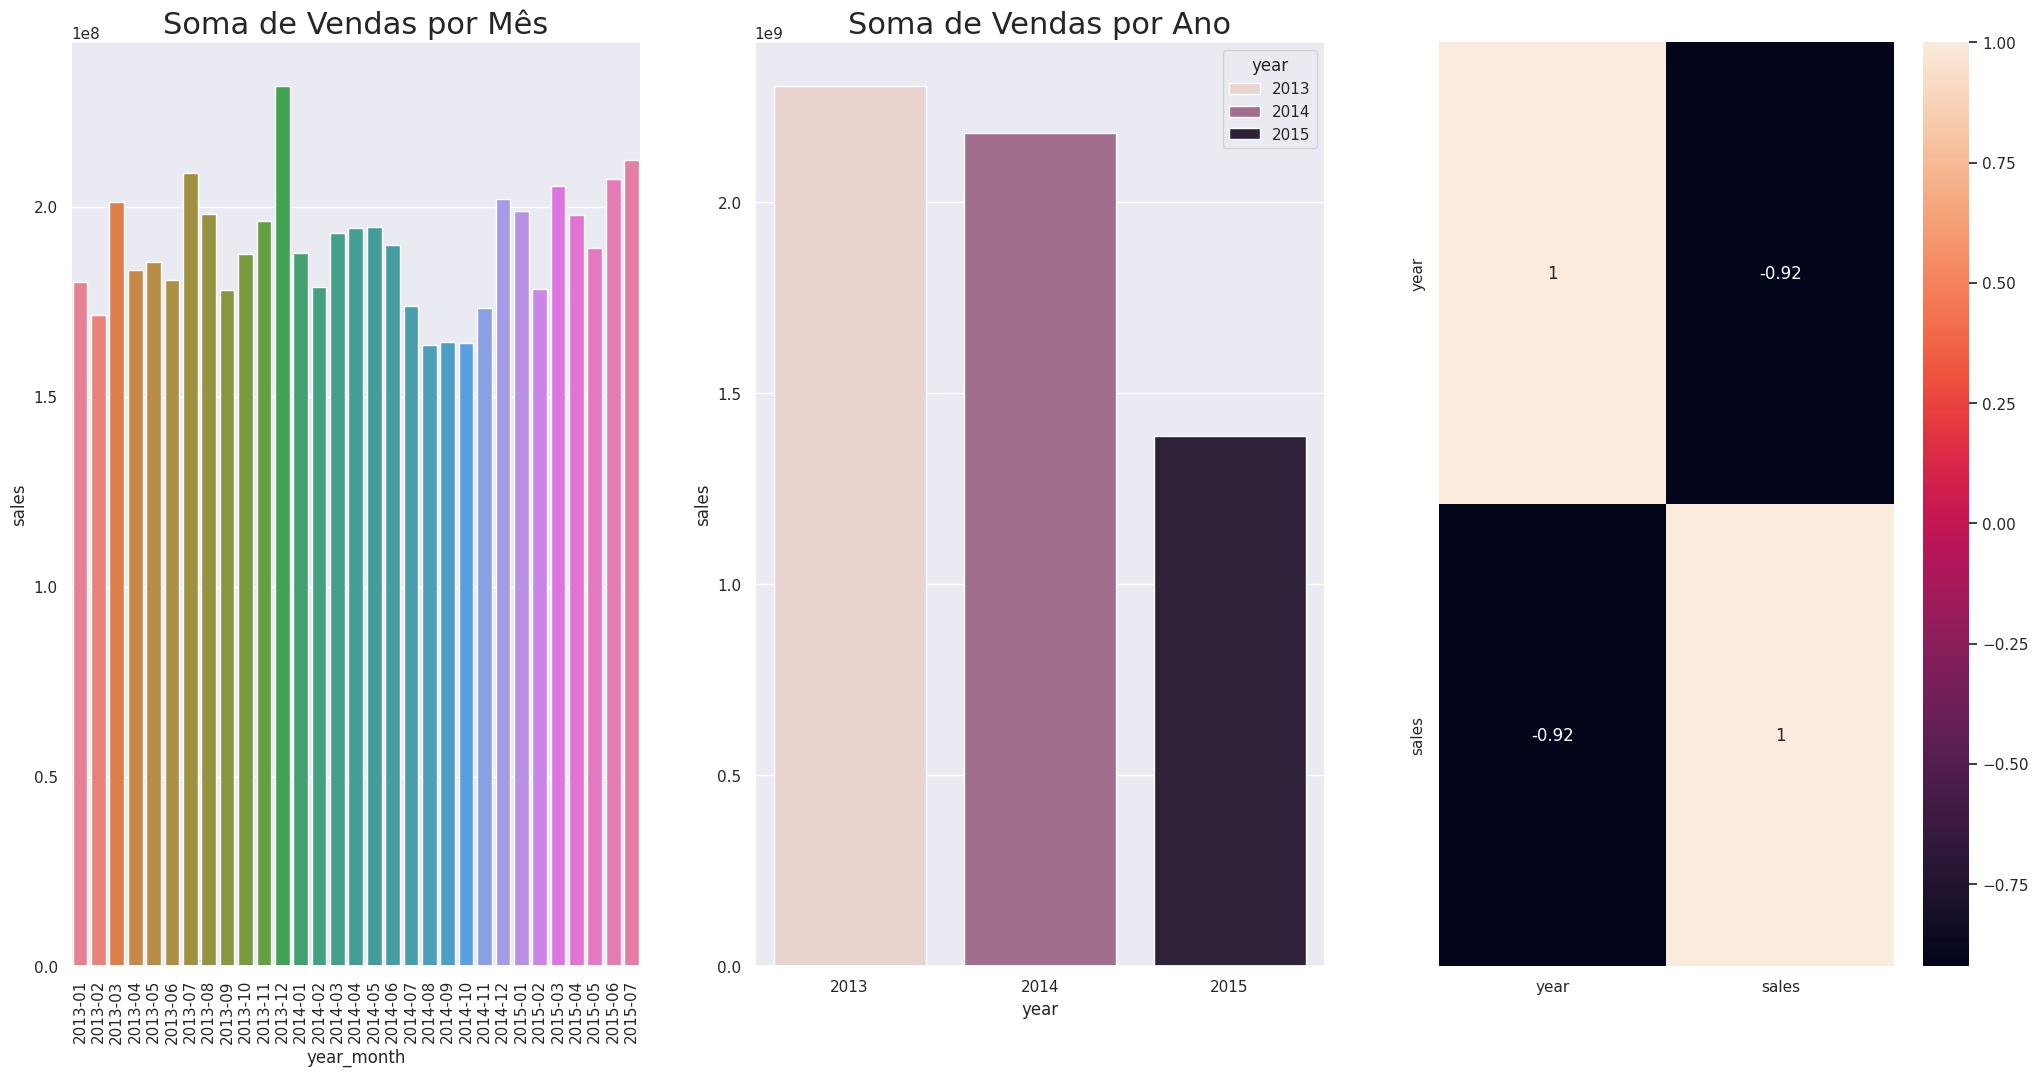

In [40]:
aux1 = df4[['year_month', 'sales']].groupby('year_month').sum().reset_index()
aux2 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.subplot(1,3,1)
sns.barplot(x='year_month', y= 'sales', data = aux1, hue = 'year_month')
plt.xticks(rotation = 90)
plt.title('Soma de Vendas por Mês', size = 22)

plt.subplot(1,3,2)
sns.barplot(x='year', y= 'sales', data = aux2, hue = 'year')
plt.title('Soma de Vendas por Ano', size = 22)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True);


## 4.3 Análise Multivariada

### 4.3.1 Numérical Attributes

In [41]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64', 'int32'])

columns = ['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo']

<Axes: >

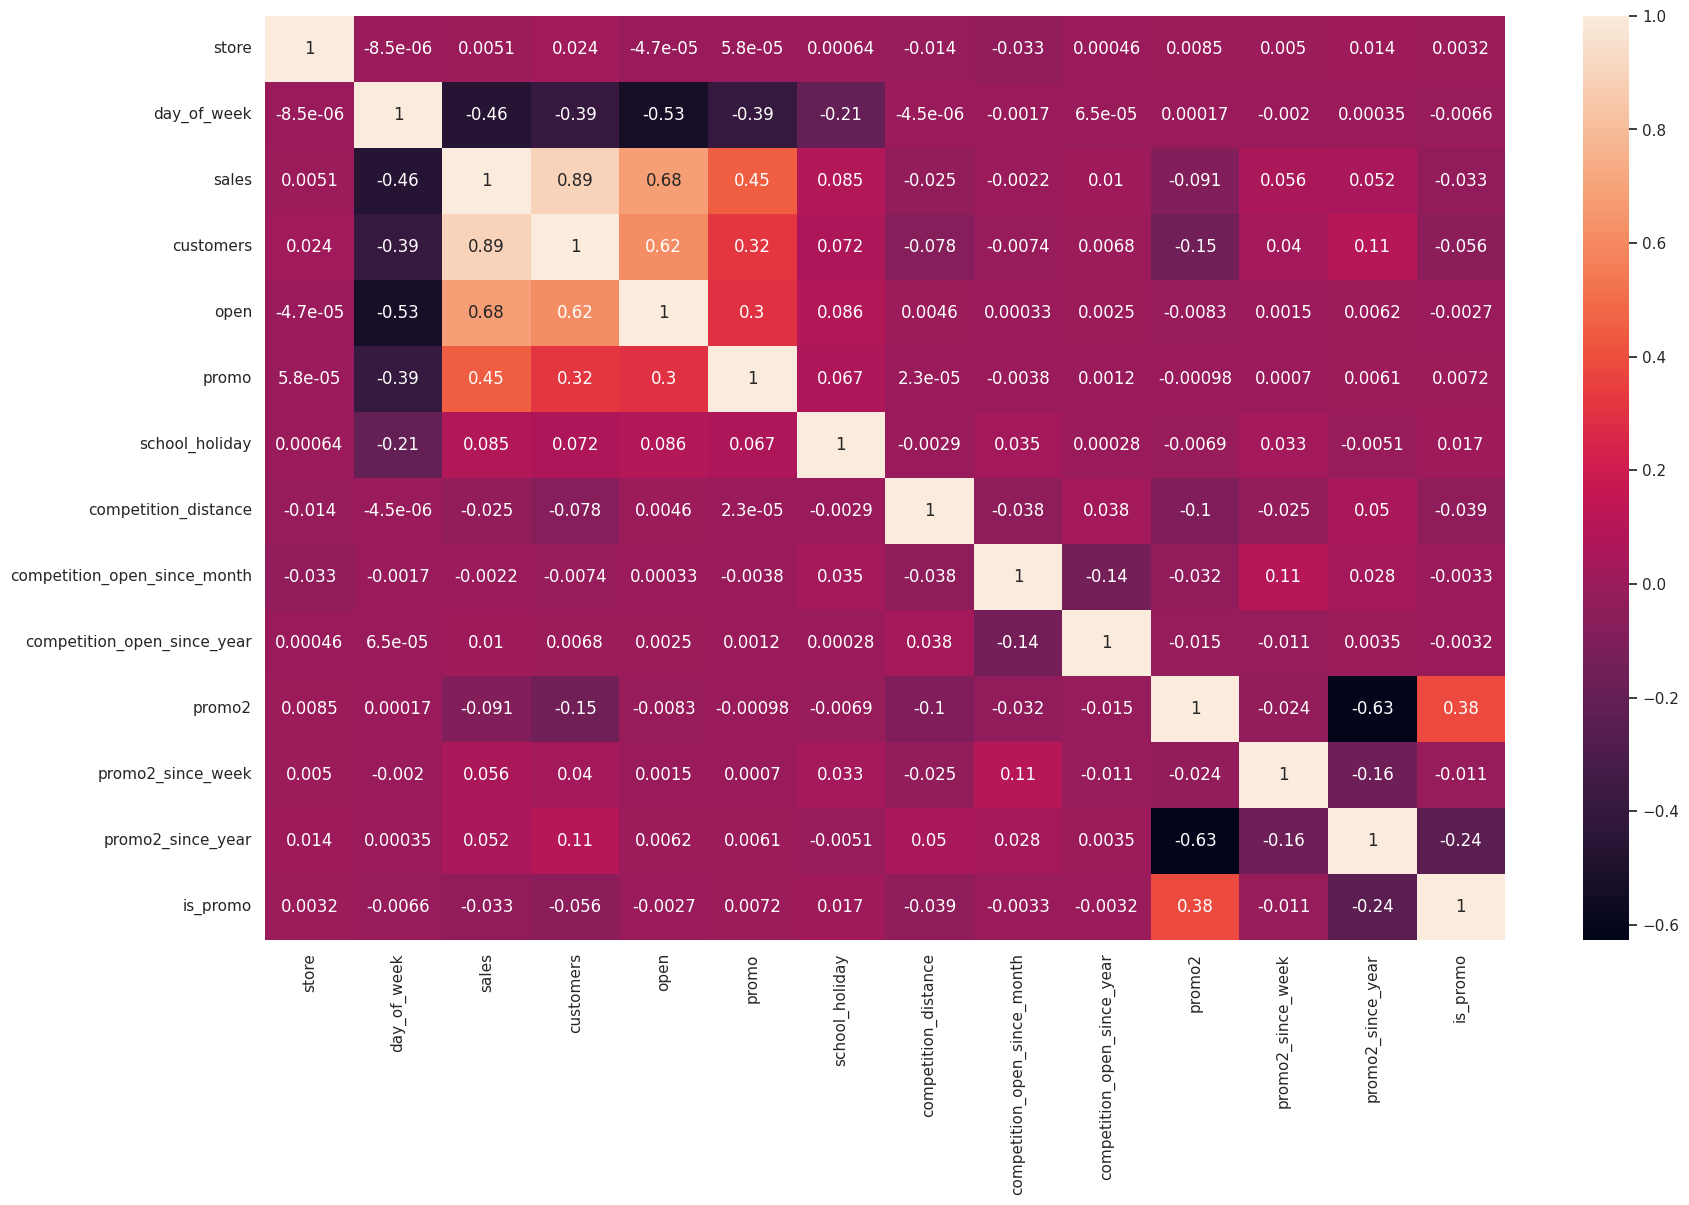

In [42]:
plt.figure(figsize= (20,12))
correlation = num_attributes[columns].corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2  Categorical Attributes

In [43]:
cat_attributes = df4.select_dtypes(include ='object')
colunas = ['state_holiday', 'store_type', 'assortment']
aux = cat_attributes[colunas]

<Axes: >

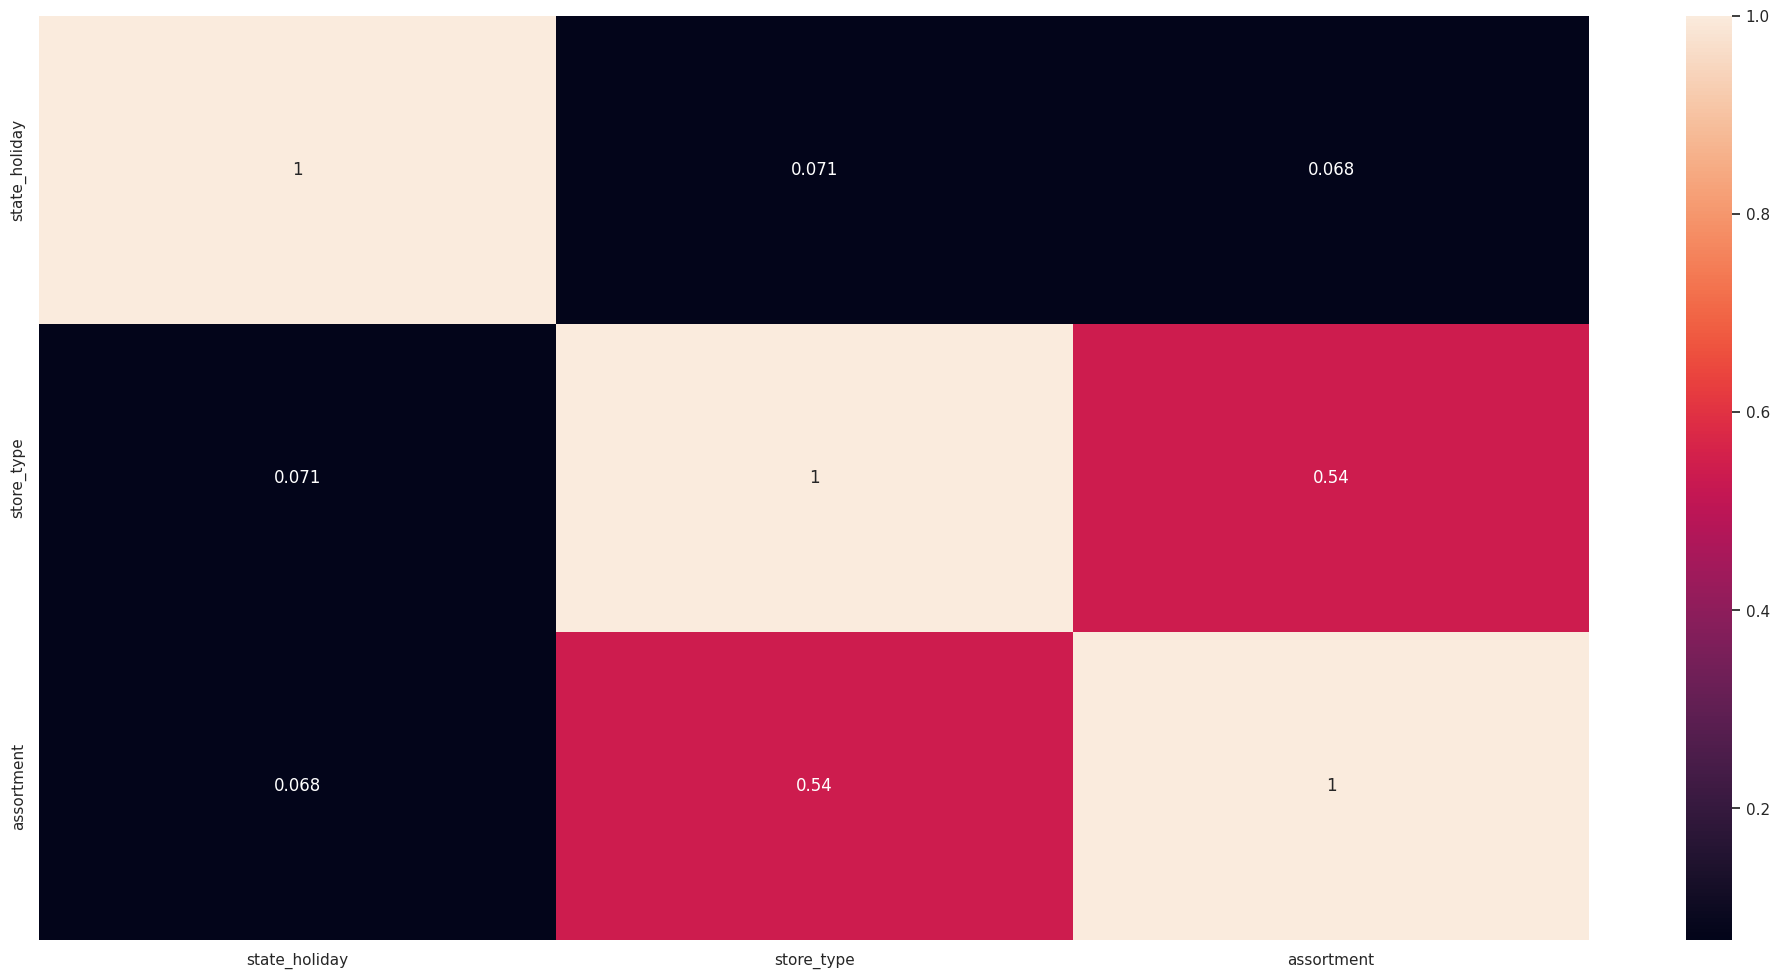

In [44]:
a1 = cramer_v(aux['state_holiday'], aux['state_holiday'])
a2 = cramer_v(aux['state_holiday'], aux['store_type'])
a3 = cramer_v(aux['state_holiday'], aux['assortment'])

a4 = cramer_v(aux['store_type'], aux['state_holiday'])
a5 = cramer_v(aux['store_type'], aux['store_type'])
a6 = cramer_v(aux['store_type'], aux['assortment'])

a7 = cramer_v(aux['assortment'], aux['state_holiday'])
a8 = cramer_v(aux['assortment'], aux['store_type'])
a9 = cramer_v(aux['assortment'], aux['assortment'])

corr_cat = pd.DataFrame({'state_holiday': [a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

corr_cat = corr_cat.set_index(corr_cat.columns)
sns.heatmap(corr_cat, annot=True)

# 5.0 Passo 5- DATA PREPARATION

In [45]:
df5 = df4.copy()

df5['week_of_year'] = df5['year_week'].apply(lambda x: int(x.split('-')[1]))
aux = df5.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week 
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3 Transformation

### 5.3.1 Encoding

In [47]:
# state_holiday
df5 =pd.get_dummies(aux, prefix=['state_holiday'], columns = ['state_holiday'])
df5['state_holiday_christmas']=df5['state_holiday_christmas'].astype(int)
df5['state_holiday_easter_holiday']=df5['state_holiday_easter_holiday'].astype(int)
df5['state_holiday_public_holiday']=df5['state_holiday_public_holiday'].astype(int)
df5['state_holiday_regular_day']=df5['state_holiday_regular_day'].astype(int)
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( aux['store_type'])

# assortment
assortment_dict = {'basic': 1,
                  'extended': 2,
                  'extra': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [48]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transform

In [49]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (np.pi/7 ) ) )

# month 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (np.pi/52 ) ) )

# 6.0 Passo 6- Feature Selection

In [17]:
df6 = df5.copy()

NameError: name 'df5' is not defined

In [3]:
# df6.to_csv('data/df_modulo_6.csv')
df6 = pd.read_csv('data/df_modulo_6.csv', parse_dates=['date'])

## 6.1 Split datafrane into training and test dataset 

In [4]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week','year_month']
df6 = df6.drop(cols_drop, axis= 1)

In [5]:
time_max = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)
print(time_max)

2015-06-19 00:00:00


In [6]:
# training dataset
X_train = df6[df6['date']< time_max]
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date']>= time_max]
y_test = X_test['sales']

print(f'Training Min Date: { X_train[['store', 'date']].groupby('store').min().reset_index()['date'][0]}')
print(f'Training Max Date: { X_train[['store', 'date']].groupby('store').max().reset_index()['date'][0]}\n')

print(f'Test Min Date:     { X_test[['store', 'date']].groupby('store').min().reset_index()['date'][0]}')
print(f'Test Max Date:     { X_test[['store', 'date']].groupby('store').max().reset_index()['date'][0]}')

Training Min Date: 2013-01-02 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date:     2015-06-19 00:00:00
Test Max Date:     2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [14]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
# boruta = BorutaPy( rf , n_estimators= 'auto', verbose = 2, random_state=42).fit( X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [15]:
# cols_selected = boruta.support_.tolist()

# # best features 
# X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta 
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


# cols_selected_boruta
# ['Unnamed: 0',
#  'store',
#  'promo',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo2',
#  'promo2_since_week',
#  'promo2_since_year',
#  'competition_time_month',
#  'promo_time_week',
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'day_sin',
#  'day_cos',
# 'week_of_year_cos']

# cols_not_selected_boruta
# ['is_promo',
#  'month_cos',
#  'month_sin',
#  'school_holiday',
#  'state_holiday_christmas',
#  'state_holiday_easter_holiday',
#  'state_holiday_public_holiday',
#  'state_holiday_regular_day',
#  'week_of_year_sin',
#  'year']


## 6.3 Manual Feature Selection

In [22]:
cols_selected_boruta =  ['Unnamed: 0',
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
'week_of_year_sin',
'week_of_year_cos']

cols_not_selected_boruta = ['is_promo',
 'month_cos',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']

# columns to add
feat_to_add = ['date', 'sales']
# final features
cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta

['Unnamed: 0',
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']